In [63]:
%cd "~/code/snet/moses-incons-pen-xp"
%load_ext autoreload
%autoreload
%matplotlib inline

/home/xabush/code/snet/moses-incons-pen-xp
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import numpy as np
import jax
import jax.random as rng
import jax.numpy as jnp
import numpyro as npyro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
import arviz as az
import scipy
import scipy.stats as st
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from notebooks.variable_selection.MosesEstimator import *
from notebooks.variable_selection.util import *
from sklearn.model_selection import train_test_split, KFold
from scripts.samplers import *
import warnings
warnings.filterwarnings('ignore')


In [4]:
tamox_df = pd.read_csv("data/old_cancer_data/tamoxBinary.csv.xz")
biogrid_net_df = pd.read_table("data/old_cancer_data/BIOGRID-ORGANISM-Homo_sapiens-4.4.211.tab3.txt")
biogrid_net_df = biogrid_net_df[pd.to_numeric(biogrid_net_df["Entrez Gene Interactor A"], errors="coerce").notnull()]
biogrid_net_df = biogrid_net_df[pd.to_numeric(biogrid_net_df["Entrez Gene Interactor B"], errors="coerce").notnull()]
biogrid_net_df["Entrez Gene Interactor A"] = biogrid_net_df["Entrez Gene Interactor A"].astype(np.int)
biogrid_net_df["Entrez Gene Interactor B"] = biogrid_net_df["Entrez Gene Interactor B"].astype(np.int)

In [66]:
biogrid_net_df.iloc[:100]

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6651,2908,11319,109165,116450,-,-,NR3C1,ECD,GCCR|GCR|GCRST|GR|GRL,...,-,NP_001129224|NP_001129225|NP_009196,-,-,-,-,-,-,Homo sapiens,Homo sapiens
96,6722,2645,5208,108915,111229,-,RP11-164O23.2,GCK,PFKFB2,FGQTL3|GK|GLK|HHF3|HK4|HKIV|HXKP|LGLK|MODY2,...,B4DY91|F6XNB3,NP_001018063|NP_006203,-,-,-,-,-,-,Homo sapiens,Homo sapiens
97,6764,3309,1801,109541,108135,-,-,HSPA5,DPH1,BIP|GRP78|HEL-S-89n|MIF2,...,B3KQW7,NP_001333504|NP_001333505|NP_001374|NP_001333503,-,-,-,-,-,-,Homo sapiens,Homo sapiens
98,6781,6514,3838,112405,110036,-,-,SLC2A2,KPNA2,GLUT2,...,Q7Z726,NP_001307540|NP_002257,-,-,-,-,-,-,Homo sapiens,Homo sapiens


In [5]:
biogrid_net = pd.Series(biogrid_net_df["Entrez Gene Interactor B"].values, index=biogrid_net_df["Entrez Gene Interactor A"])
biogrid_net

Entrez Gene Interactor A
6416         2318
84665          88
90           2339
2624         5371
6118         6774
            ...  
43740572     6772
43740572     6773
43740572    57506
55016       23035
23035       55016
Length: 1054929, dtype: int64

In [6]:
hgnc_gene_sym_df = pd.read_csv("data/old_cancer_data/hgncSymbolMap6jul22long.csv")
hgnc_gene_sym_df = hgnc_gene_sym_df[pd.to_numeric(hgnc_gene_sym_df["NCBI Gene ID"], errors="coerce").notnull()]
hgnc_gene_sym_df["NCBI Gene ID"] = hgnc_gene_sym_df["NCBI Gene ID"].astype(np.int)
hgnc_gene_sym_df = hgnc_gene_sym_df.drop_duplicates("NCBI Gene ID")
gene_id_mapping = pd.Series(hgnc_gene_sym_df["NCBI Gene ID"].values,
                            index=hgnc_gene_sym_df["Approved symbol"]).to_dict()
gene_id_rev_mapping = pd.Series(hgnc_gene_sym_df["Approved symbol"].values,
                                index=hgnc_gene_sym_df["NCBI Gene ID"]).to_dict()
gene_syms = tamox_df.columns.tolist()
not_matched_syms = []
gene_ids = []
for gene in gene_syms:
    if gene in gene_id_mapping:
        gene_ids.append(gene_id_mapping[gene])
    else:
        not_matched_syms.append(gene)

print(len(gene_ids))

7343


In [7]:
cosmic_genes_df = pd.read_csv("data/old_cancer_data/cosmic_genes.csv")
cosmic_genes_df = cosmic_genes_df[pd.to_numeric(cosmic_genes_df["Entrez GeneId"], errors="coerce").notnull()]
cosmic_genes_df["Entrez GeneId"] = cosmic_genes_df["Entrez GeneId"].astype(np.int)
cosmic_genes_sym = cosmic_genes_df["Gene Symbol"].tolist()
cosmic_genes_ids = cosmic_genes_df["Entrez GeneId"].tolist()

In [8]:
cosmic_genes_not_matched = []
cosmic_genes_matched = []
cosmic_genes_matched_id = []
for i, gene in enumerate(cosmic_genes_sym):
    if gene in gene_syms:
        cosmic_genes_matched.append(gene)
        cosmic_genes_matched_id.append(cosmic_genes_ids[i])
    else:
        cosmic_genes_not_matched.append(gene)

print(f"Length of not matched cosmic genes: {len(cosmic_genes_not_matched)}")

Length of not matched cosmic genes: 228


In [9]:
cosmic_hgnc_mismatch = []
for gene in cosmic_genes_sym:
    if not gene in gene_id_mapping:
        cosmic_hgnc_mismatch.append(gene)

cosmic_hgnc_mismatch_id = []
for i, gene in enumerate(cosmic_hgnc_mismatch):
    cosmic_hgnc_mismatch_id.append(cosmic_genes_df.iloc[i]["Entrez GeneId"])

print(len(cosmic_hgnc_mismatch))

71


In [10]:
cosmic_hgnc_mismatch_id

[29974,
 10006,
 25,
 27,
 57007,
 2181,
 23305,
 90,
 91,
 92,
 4301,
 4299,
 3899,
 27125,
 10142,
 207,
 208,
 10000,
 217,
 238,
 139285,
 286,
 324,
 9582,
 367,
 369,
 23092,
 2909,
 394,
 9639,
 55160,
 23365,
 8289,
 57492,
 196528,
 405,
 79058,
 171023,
 55252,
 466,
 471,
 472,
 476,
 492,
 545,
 546,
 8312,
 8313,
 567,
 8314,
 580,
 581,
 11177,
 8915,
 53335,
 64919,
 596,
 83596,
 602,
 604,
 605,
 607,
 283149,
 9774,
 54880,
 63035,
 613,
 330,
 57448,
 641,
 653]

In [11]:
erbb2_syms, estrogen_syms, tamox_path_syms = [], [], []
erbb2_ids, estrogen_ids, tamox_path_ids = [], [], []
with open("data/old_cancer_data/tamoxifen_pathway_syms.txt", "r") as fp:
    for g in fp.readlines():
        g = g.strip()
        if g in gene_id_mapping and g in gene_syms:
            tamox_path_syms.append(g)
            tamox_path_ids.append(gene_id_mapping[g])

with open("data/old_cancer_data/erbb2_signalling.txt", "r") as fp:
    for g in fp.readlines():
        g = g.strip()
        if g in gene_id_mapping and g in gene_syms:
            erbb2_syms.append(g)
            erbb2_ids.append(gene_id_mapping[g])

with open("data/old_cancer_data/estrogen_signalling_syms.txt", "r") as fp:
    for g in fp.readlines():
        g = g.strip()
        if g in gene_id_mapping and g in gene_syms:
            estrogen_syms.append(g)
            estrogen_ids.append(gene_id_mapping[g])

print(f"Tamoxifen Path: {len(tamox_path_syms)}, ERRB2 Path: {len(erbb2_syms)}, Estrogen Path: {len(estrogen_syms)}")

tamox_intr = len(list(set(tamox_path_syms) & set(gene_syms)))
erbb2_intr = len(list(set(erbb2_syms) & set(gene_syms)))
estrogen_intr = len(list(set(estrogen_syms) & set(gene_syms)))
print(f"Tamoxifen-All intr: {tamox_intr}, ERBB2-All intr: {erbb2_intr}, Estrogen-All intr: {estrogen_intr}")
tamox_cosmic_intr = len(list(set(tamox_path_syms) & set(cosmic_genes_matched)))
errb_cosmic_intr = len(list(set(erbb2_syms) & set(cosmic_genes_matched)))
estrogen_cosmic_intr = len(list(set(estrogen_syms) & set(cosmic_genes_matched)))
print(f"Tamoxifen-Cosmic intr: {tamox_cosmic_intr}, ERBB2-Cosmic intr: {errb_cosmic_intr}, Estrogen-Cosmic intr: {estrogen_cosmic_intr}")

Tamoxifen Path: 6, ERRB2 Path: 32, Estrogen Path: 104
Tamoxifen-All intr: 6, ERBB2-All intr: 32, Estrogen-All intr: 104
Tamoxifen-Cosmic intr: 1, ERBB2-Cosmic intr: 14, Estrogen-Cosmic intr: 33


In [12]:
# Union of tamoxifen, errb2 and cosmic genes

tee_genes = list(set(estrogen_syms) | set(tamox_path_syms) | set(erbb2_syms))
teec_genes = list(set(tee_genes + cosmic_genes_matched))
teec_genes_id = []
for g in tee_genes:
    teec_genes_id.append(gene_id_mapping[g])

teec_genes_id += cosmic_genes_matched_id

teec_genes_id = list(set(teec_genes_id))

In [13]:
tamox_teec_df = tamox_df[teec_genes]
tamox_teec_df

,DICER1,MEN1,CCND1,DDB2,PTPN11,STIL,TRIP11,CBL,ARID1A,CALR,...,USF2,CHD4,ETV6,FGFR1OP,GNGT1,ITGAV,STAG2,STAG1,BLM,CDKN2C
0,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,0,0,0
1,1,1,1,0,0,0,1,0,0,0,...,1,1,1,1,0,1,1,1,1,0
2,0,1,1,0,0,0,0,0,0,1,...,1,1,1,1,0,1,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,1,0,1,1,0
4,0,1,1,0,0,0,0,1,0,0,...,1,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,0,0,1,1,0,0,0,0,1,1,...,1,1,0,1,0,0,1,0,0,0
638,1,1,1,1,0,0,1,0,1,1,...,1,1,0,0,0,0,0,1,0,1
639,1,0,0,0,0,1,0,0,0,0,...,0,1,0,1,0,1,0,1,1,1
640,0,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,1,1,1


In [14]:
tamox_teec_df.columns = teec_genes_id

In [15]:
p = tamox_teec_df.shape[1]
J = np.zeros((p, p))
cols = tamox_teec_df.columns
for i, g1 in enumerate(cols):
    try:
        intr_genes = biogrid_net.loc[g1].tolist()
        if isinstance(intr_genes, int): intr_genes = [intr_genes]
        for g2 in intr_genes:
            if g2 in teec_genes_id:
                j = cols.get_loc(g2)
                J[i, j] = 1.0
                ## BIOGRID Interactions are not symmetric but add symmetry to ensure we are working with undirected graph
                J[j, i] = 1.0
    except KeyError:
        continue

np.count_nonzero(J)

15088

In [16]:
J_control = np.zeros((p, p))

In [17]:
X, y = tamox_teec_df.to_numpy(), tamox_df["posOutcome"].to_numpy()
seed = 1234
np.random.seed(seed)
rng_key, rng_key_predict = rng.split(rng.PRNGKey(1234))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1234)
X_train.shape

(449, 592)

In [18]:
from numpyro.infer import MCMC, MixedHMC, HMC
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform

def gamma_energy(gamma, J, eta, mu):
    return 0.5*eta*jnp.dot(jnp.dot(gamma.T, J), gamma) - mu*jnp.sum(gamma)

def model(X, y, sigma, J, eta=1.0, mu=1.0):
    L = np.linalg.cholesky(sigma)
    z = npyro.sample('z', dist.Normal(np.zeros(p), 1))
    beta = npyro.deterministic('beta', L @ z)
    # beta = npyro.sample('beta', dist.MultivariateNormal(0, sigma))
    gamma = npyro.sample('gamma', dist.Bernoulli(np.full(X.shape[1], 0.5)))
    npyro.factor('gamma_lgp', gamma_energy(gamma, J, eta, mu))
    prob = npyro.deterministic("prob", jnp.dot(X, (beta * gamma)))
    # print(f"Probs: {prob.shape}")
    likelihood = npyro.sample("y", dist.Bernoulli(logits=prob),
                              obs=y)

# sigma = 0.3 * np.ones((p, p))
# np.fill_diagonal(sigma, 25)



In [36]:
kernel = MixedHMC(HMC(model, num_steps=5))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=3, progress_bar=True)
mcmc.run(rng_key, X_train, y_train, 25*np.identity(p), J, 1.0, 1.0)

sample: 100%|██████████████████████████| 2000/2000 [25:26<00:00,  1.31it/s, 2960 steps of size 1.18e-38. acc. prob=0.70]


In [37]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[1]      0.98      0.14      1.00      1.00      1.00    447.76      1.00
  gamma[2]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[3]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[4]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[5]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[6]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[7]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[8]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[9]      0.68      0.47      1.00      0.00      1.00    366.16      1.00
 gamma[10]      1.00      0.00      1.00      1.00      1.00       nan       nan
 gamma[11]      1.00      0

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

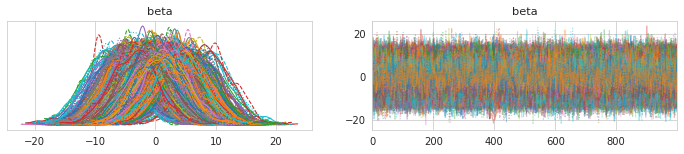

In [38]:
import arviz as az
infr_data = az.from_numpyro(mcmc)
az.plot_trace(infr_data, var_names=["beta"])

In [ ]:
kernel_2 = MixedHMC(HMC(model, num_steps=5))
mcmc_2 = MCMC(kernel_2, num_warmup=1000, num_samples=1000, num_chains=3, progress_bar=True)
mcmc_2.run(rng_key, X_train, y_train, 25*np.identity(p), J, 1.0, 10.0)

sample: 100%|████████████████████████| 2000/2000 [1:03:11<00:00,  1.90s/it, 2960 steps of size 1.79e-06. acc. prob=0.79]


In [41]:
mcmc_2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[1]      0.02      0.14      0.00      0.00      0.00    230.61      1.01
  gamma[2]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[3]      0.21      0.41      0.00      0.00      1.00    408.31      1.01
  gamma[4]      0.99      0.11      1.00      1.00      1.00    564.57      1.01
  gamma[5]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[6]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[7]      1.00      0.00      1.00      1.00      1.00       nan       nan
  gamma[8]      0.98      0.13      1.00      1.00      1.00    712.46      1.00
  gamma[9]      0.00      0.00      0.00      0.00      0.00       nan       nan
 gamma[10]      0.35      0.48      0.00      0.00      1.00    305.72      1.00
 gamma[11]      1.00      0

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

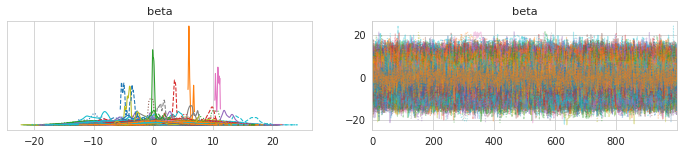

In [42]:
infr_data = az.from_numpyro(mcmc_2)
az.plot_trace(infr_data, var_names=["beta"])

In [43]:
kernel_3 = MixedHMC(HMC(model, num_steps=5))
mcmc_3 = MCMC(kernel_3, num_warmup=1000, num_samples=1000, num_chains=3, progress_bar=True)
mcmc_3.run(rng_key, X_train, y_train, 25*np.identity(p), J_control, 1.0, 1.0)

sample: 100%|██████████████████████████| 2000/2000 [27:30<00:00,  1.21it/s, 2960 steps of size 1.90e+16. acc. prob=0.78]


In [44]:
mcmc_3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  gamma[0]      0.20      0.40      0.00      0.00      1.00    303.69      1.01
  gamma[1]      0.34      0.47      0.00      0.00      1.00    126.88      1.01
  gamma[2]      0.24      0.43      0.00      0.00      1.00    240.72      1.01
  gamma[3]      0.26      0.44      0.00      0.00      1.00    164.56      1.02
  gamma[4]      0.20      0.40      0.00      0.00      1.00    368.01      1.01
  gamma[5]      0.25      0.43      0.00      0.00      1.00    254.60      1.02
  gamma[6]      0.62      0.49      1.00      0.00      1.00     71.69      1.06
  gamma[7]      0.26      0.44      0.00      0.00      1.00    224.29      1.02
  gamma[8]      0.28      0.45      0.00      0.00      1.00    223.03      1.02
  gamma[9]      0.17      0.37      0.00      0.00      1.00    421.72      1.00
 gamma[10]      0.17      0.37      0.00      0.00      1.00    539.03      1.01
 gamma[11]      0.18      0

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

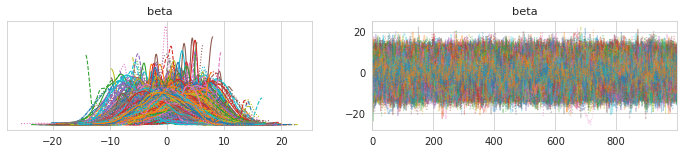

In [45]:
import arviz as az
infr_data = az.from_numpyro(mcmc_3)
az.plot_trace(infr_data, var_names=["beta"])

In [61]:
average_length_np(gamma_samples_2)

377.899

In [47]:
gamma_samples = jax.device_get(mcmc.get_samples()["gamma"])
beta_samples = jax.device_get(mcmc.get_samples()["beta"])
jnp.save("data/np_data/gamma_samples_nb_tamox_2.npy", gamma_samples)
jnp.save("data/np_data/beta_samples_nb_tamox_2.npy", beta_samples)

In [48]:
gamma_samples_2 = jax.device_get(mcmc_2.get_samples()["gamma"])
beta_samples_2 = jax.device_get(mcmc_2.get_samples()["beta"])
jnp.save("data/np_data/gamma_samples_2_nb_tamox_2.npy", gamma_samples_2)
jnp.save("data/np_data/beta_samples_2_nb_tamox_2.npy", beta_samples_2)

In [49]:
gamma_samples_3 = jax.device_get(mcmc_3.get_samples()["gamma"])
beta_samples_3 = jax.device_get(mcmc_3.get_samples()["beta"])
jnp.save("data/np_data/gamma_samples_3_nb_tamox_2.npy", gamma_samples_3)
jnp.save("data/np_data/beta_samples_3_nb_tamox_2.npy", beta_samples_3)

In [19]:
gamma_samples = jnp.load("data/np_data/gamma_samples_nb_tamox_2.npy")
beta_samples = jnp.load("data/np_data/beta_samples_nb_tamox_2.npy")

gamma_samples_2 = jnp.load("data/np_data/gamma_samples_2_nb_tamox_2.npy")
beta_samples_2 = jnp.load("data/np_data/beta_samples_2_nb_tamox_2.npy")


gamma_samples_3 = jnp.load("data/np_data/gamma_samples_3_nb_tamox_2.npy")
beta_samples_3 = jnp.load("data/np_data/beta_samples_3_nb_tamox_2.npy")

In [37]:
feats_1_eng_idx, feats_1_eng = rank_hmc_feats_eng(gamma_samples, beta_samples, X_train, y_train, J, 1.0, 1.0)
feats_2_eng_idx, feats_2_eng = rank_hmc_feats_eng(gamma_samples_2, beta_samples_2, X_train, y_train, J, 1.0, 10.0)
feats_3_eng_idx, feats_3_eng = rank_hmc_feats_eng(gamma_samples_3, beta_samples_3, X_train, y_train, J_control, 1.0, 1.0)

In [69]:
feats_1_top1000 = gamma_samples[feats_1_eng_idx]
feats_2_top1000 = gamma_samples_2[feats_2_eng_idx]
feats_3_top1000 = gamma_samples_3[feats_3_eng_idx]

In [70]:
u1, c1 = np.unique(feats_1_top1000, return_counts=True, axis=0)
count_idx_1 = np.argsort(c1)[::-1]
u2, c2 = np.unique(feats_2_top1000, return_counts=True, axis=0)
count_idx_2 = np.argsort(c2)[::-1]
u3, c3 = np.unique(feats_3_top1000, return_counts=True, axis=0)
count_idx_3 = np.argsort(c3)[::-1]

In [71]:
feats_sel_1_top1000 = samples_to_feats(u1)
feats_sel_2_top1000 = samples_to_feats(u2)
feats_sel_3_top1000 = samples_to_feats(u3)

In [72]:
res_1_log_df = run_fs_logreg(X_train, X_test, y_train, y_test, 1234, feats_sel_1_top1000)
res_2_log_df = run_fs_logreg(X_train, X_test, y_train, y_test, 1234, feats_sel_2_top1000)
res_3_log_df = run_fs_logreg(X_train, X_test, y_train, y_test, 1234, feats_sel_3_top1000)

100%|█████████████████████████████████████████████████████████| 2362/2362 [08:01<00:00,  4.91it/s, l_tr=0.60, l_te=0.62]


In [73]:
res_1_log_df.describe()

,log_cv_score,log_test_score
count,2115.000000,2115.000000
mean,0.649421,0.580838
std,0.007479,0.005896
min,0.620385,0.558409
25%,0.644321,0.576636
50%,0.649497,0.580641
75%,0.654456,0.584921
max,0.674279,0.610743


In [74]:
res_2_log_df.describe()

,log_cv_score,log_test_score
count,2383.000000,2383.000000
mean,0.656235,0.568533
std,0.007543,0.009434
min,0.630476,0.533692
25%,0.651407,0.561999
50%,0.656401,0.568489
75%,0.661186,0.574841
max,0.682277,0.599144


In [75]:
res_3_log_df.describe()

,log_cv_score,log_test_score
count,2362.000000,2362.000000
mean,0.621201,0.572552
std,0.030586,0.033737
min,0.521785,0.468655
25%,0.601209,0.549986
50%,0.622095,0.572839
75%,0.640059,0.595105
max,0.741900,0.687517


In [80]:
test_max_idx_1 = res_1_log_df.idxmax()["log_cv_score"]
test_max_idx_2 = res_2_log_df.idxmax()["log_cv_score"]
test_max_idx_3 = res_3_log_df.idxmax()["log_cv_score"]

In [60]:
res_1_moses_df = run_fs_moses(X_train, X_test, y_train, y_test, 1234, [feats_sel_1_top1000[test_max_idx_1]])
# res_1_df.to_csv("data/res_tamox_2_feats_1.csv", index=False)-
res_1_moses_df

100%|████████████████████████████████████████| 1/1 [04:07<00:00, 247.50s/it, m_tr=0.55, m_te=0.60, l_tr=0.60, l_te=0.62]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.548874,0.596451,0.596737,0.623378


In [62]:
res_2_moses_df = run_fs_moses(X_train, X_test, y_train, y_test, 1234, [feats_sel_2_top1000[test_max_idx_2]])
res_2_moses_df

100%|█████████████████████████████████████████| 1/1 [01:33<00:00, 93.14s/it, m_tr=0.52, m_te=0.60, l_tr=0.58, l_te=0.62]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.522977,0.603494,0.58412,0.616335


In [61]:
res_3_moses_df = run_fs_moses(X_train, X_test, y_train, y_test, 1234, [feats_sel_3_top1000[test_max_idx_3]])
res_3_moses_df

100%|█████████████████████████████████████████| 1/1 [00:48<00:00, 48.83s/it, m_tr=0.55, m_te=0.59, l_tr=0.53, l_te=0.62]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.552062,0.589685,0.526544,0.615576


In [98]:
gene_ids_feats_3 = tamox_teec_df.iloc[:,feats_3_top1000[res_3_log_df.idxmax()["log_test_score"]]].columns.tolist()

tamox_path_intr = list(set(gene_ids_feats_3) & set(tamox_path_ids))
estrogen_sig_intr = list(set(gene_ids_feats_3) & set(estrogen_ids))
erbb2_intr = list(set(gene_ids_feats_3) & set(erbb2_ids))
print(f"Num overlap with estrogen signalling: {len(estrogen_sig_intr)}\nNum overlap with Erbb2: {len(erbb2_intr)}\nNum overlap with Tamox path: {len(tamox_path_intr)}")
len(list(set(erbb2_intr) | set(estrogen_sig_intr)))

Num overlap with estrogen signalling: 0
Num overlap with Erbb2: 0
Num overlap with Tamox path: 0


0

In [56]:
ar = np.arange(p)
idx = np.mean(gamma_samples_2, axis=0) == 1
f_idx = ar[idx]
len(f_idx)

267

In [57]:
run_fs_logreg(X_train, X_test, y_train, y_test, 1234, [f_idx])

100%|███████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it, l_tr=0.64, l_te=0.63]


,log_cv_score,log_test_score
0,0.641587,0.629108


In [86]:
var = np.var(beta_samples_3, axis=0)
abs_mean = np.abs(np.mean(beta_samples_3, axis=0))
np.quantile(var, q=[0, 0.25, 0.5, 0.75, 1])

array([ 9.60257149, 19.9867487 , 21.70443439, 23.26121664, 41.07587051])

In [87]:
np.quantile(abs_mean, q=[0, 0.25, 0.5, 0.75, 1])

array([4.78028611e-04, 2.60713913e-01, 6.31870270e-01, 1.34726986e+00,
       8.56793976e+00])

In [90]:
idx = np.logical_and(abs_mean > 1, np.ones(p))
ar = np.arange(p)
feats_idx = ar[idx]
feat_sel = np.zeros(p)
feat_sel[feats_idx] = np.mean(beta_samples_2[:,feats_idx], axis=0)
feats_idx

array([  1,   6,  12,  15,  21,  22,  27,  29,  33,  39,  43,  46,  47,
        48,  52,  53,  64,  67,  72,  77,  82,  84,  86,  88,  90,  93,
        97,  99, 102, 103, 104, 105, 111, 117, 119, 127, 132, 134, 137,
       141, 142, 143, 146, 147, 150, 151, 154, 157, 162, 169, 171, 175,
       177, 180, 181, 182, 183, 185, 192, 196, 198, 200, 201, 202, 204,
       205, 208, 209, 212, 214, 217, 226, 227, 229, 230, 233, 235, 237,
       240, 246, 250, 253, 256, 265, 267, 268, 269, 271, 275, 281, 283,
       289, 294, 297, 298, 300, 303, 304, 305, 308, 310, 312, 318, 320,
       321, 325, 330, 334, 336, 337, 346, 348, 350, 351, 352, 354, 355,
       356, 359, 361, 366, 367, 369, 372, 374, 375, 376, 382, 390, 392,
       395, 396, 399, 407, 408, 409, 414, 416, 420, 425, 427, 429, 430,
       443, 445, 449, 450, 451, 453, 454, 457, 458, 460, 461, 463, 468,
       469, 470, 471, 472, 473, 474, 480, 482, 483, 498, 504, 505, 506,
       514, 515, 516, 521, 525, 526, 529, 534, 535, 536, 541, 54

In [91]:
run_fs_logreg(X_train, X_test, y_train, y_test, 1234, [feats_idx])

100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s, l_tr=0.61, l_te=0.57]


,log_cv_score,log_test_score
0,0.611764,0.574151


In [311]:
run_fs_moses(X_train, X_test, y_train, y_test, 1234, [feats_idx])

100%|█████████████████████████████████████████████| 1/1 [00:38<00:00, 38.91s/it, m_tr=0.53, m_te=0.55, l_tr=0.51, l_te=0.54]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.531882,0.546672,0.512855,0.535695


In [253]:
tamox_teec_df.iloc[:,352]

0      0
1      0
2      0
3      1
4      0
      ..
637    0
638    0
639    1
640    1
641    1
Name: 7248, Length: 642, dtype: int64

In [ ]:
res_2_df = run_fs_moses(X_train, X_test, y_train, y_test, 1234, feats_2_top100)
res_2_df.to_csv("data/res_tamox_2_feats_2.csv", index=False)
res_2_df.describe()

In [ ]:
res_3_df = run_fs_moses(X_train, X_test, y_train, y_test, 1234, feats_3_top100)
res_3_df.to_csv("data/res_tamox_2_feats_3.csv", index=False)
res_3_df.describe()

In [ ]:
step_limit = np.sqrt(np.real(np.linalg.eigvals(np.cov(X_train, rowvar=False)))[-1])
step_limit

In [ ]:
%autoreload
from numpyro.infer import MixedHMC
kernel_4 = MixedHMC(HMC(model, num_steps=5, step_size=2.5e-36, adapt_step_size=False))
mcmc_4 = MCMC(kernel_4, num_warmup=50, num_samples=100, num_chains=3, progress_bar=True)
mcmc_4.run(rng_key, X_train, y_train, 25*np.identity(p), J, 10.0, 100.0)

sample: 100%|████████████████████████████████| 150/150 [11:27<00:00,  4.58s/it, 2960 steps of size 2.50e-36. acc. prob=0.00]


In [186]:
mcmc_4.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -5.10      2.40     -3.84     -8.46     -3.11      1.51     22.28
   beta[1]      0.66      2.31      0.68     -2.47      3.45      1.52     30.17
   beta[2]      4.61      4.01      5.40     -0.71      9.07      1.51     38.36
   beta[3]      2.14      2.39      1.18     -0.19      5.59      1.51     42.52
   beta[4]     -3.51      2.91     -5.34     -5.78      0.69      1.51     37.64
   beta[5]      5.40      1.03      5.31      4.06      6.70      1.53      9.74
   beta[6]     -1.61      1.68     -2.11     -3.36      0.64      1.51     27.44
   beta[7]     -3.47      4.07     -5.17     -7.38      2.22      1.51     68.55
   beta[8]      3.85      4.64      5.51     -2.50      8.40      1.51     29.37
   beta[9]     -0.91      6.75     -0.56     -9.34      7.28      1.51     67.88
  beta[10]      6.19      3.46      5.29      2.44     10.77      1.51     41.78
  beta[11]      3.03      3

In [169]:
npyro.__file__

'/home/xabush/miniconda3/lib/python3.9/site-packages/numpyro/__init__.py'

In [ ]:
import distrax
mean = np.mean(beta_samples, axis=0)
cov = np.cov(beta_samples, rowvar=False)
mvn = distrax.MultivariateNormalFullCovariance(mean, covariance_matrix=cov)

In [40]:
mvn.log_prob(beta_samples[0])

DeviceArray(-1573.1968, dtype=float32)

In [44]:
%autoreload
potential_fn = generate_potential_energy_fn(X_train, y_train, J, cov, 1.0, 10.0, mean)

In [45]:
potential_fn(gamma_samples[0], beta_samples[0])

DeviceArray(416.98682, dtype=float32)

In [46]:
samples_eng = np.zeros(gamma_samples.shape[0])
for i in range(gamma_samples.shape[0]):
    samples_eng[i] = potential_fn(gamma_samples[i], beta_samples[i])

In [ ]:
idx = gamma_samples[2160] == 1
f_idx = np.arange(0, 592)[idx]

In [ ]:
clf = LogisticRegression()
clf.fit(X_train[:,f_idx], y_train)
roc_auc_score(y_test, clf.predict_proba(X_test[:,f_idx])[:,1])

In [60]:
run_fs_moses(X_train, X_test, y_train, y_test, 1234, list([f_idx]))

100%|████████████████████████████████████████| 1/1 [02:43<00:00, 163.20s/it, m_tr=0.55, m_te=0.58, l_tr=0.59, l_te=0.56]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.551202,0.584921,0.586416,0.560273


In [ ]:
mcmc_2.print_summary()

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

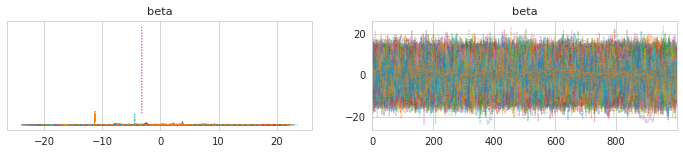

In [48]:
import arviz as az
infr_data = az.from_numpyro(mcmc_2)
az.plot_trace(infr_data, var_names=["beta"])

In [98]:
gamma_samples_2 = jax.device_get(mcmc_2.get_samples()["gamma"])
beta_samples_2 = jax.device_get(mcmc_2.get_samples()["beta"])
jnp.save("data/np_data/gamma_samples_2_nb_tamox_2.npy", gamma_samples)
jnp.save("data/np_data/beta_samples_2_nb_tamox_2.npy", beta_samples)

In [52]:
np.count_nonzero(np.abs(np.mean(beta_samples_2, axis=0)) > 1)

107

In [61]:
mean_2 = np.mean(beta_samples_2, axis=0)
cov_2 = np.cov(beta_samples_2, rowvar=False)
mvn_2 = distrax.MultivariateNormalFullCovariance(mean_2, covariance_matrix=cov_2)

potential_fn = generate_potential_energy_fn(X_train, y_train, J, cov_2, 1.0, 50.0, mean_2)
samples_eng_2 = np.zeros(gamma_samples_2.shape[0])
for i in range(gamma_samples_2.shape[0]):
    samples_eng_2[i] = potential_fn(gamma_samples_2[i], beta_samples_2[i])

In [96]:
eng_idx = np.argsort(samples_eng_2)
beta_samples_eng = beta_samples_2[eng_idx][:100]
gamma_samples_eng = gamma_samples_2[eng_idx][:100]

In [90]:
# idx = np.logical_and(np.var(beta_samples, axis=0) < 15, np.abs(np.mean(beta_samples, axis=0)) > 2)
# idx = np.logical_and(np.mean(gamma_samples, axis=0) == 1, np.ones(p))
idx = np.abs(np.mean(beta_samples_2, axis=0)) > 3
ar = np.arange(p)
feats_idx = ar[idx]
feat_sel = np.zeros(p)
feat_sel[feats_idx] = np.mean(beta_samples_2[:,feats_idx], axis=0)
feats_idx

array([161, 186, 211, 244, 474, 535])

In [91]:
run_fs_moses(X_train, X_test, y_train, y_test, 1234, list([feats_idx]))

100%|█████████████████████████████████████████| 1/1 [00:23<00:00, 23.48s/it, m_tr=0.57, m_te=0.59, l_tr=0.50, l_te=0.50]


,moses_cv_score,moses_test_score,log_cv_score,log_test_score
0,0.57169,0.587131,0.5,0.5


In [ ]:
alpha = 2
gamma_dist = distrax.Gamma(alpha, 1)
lin = np.linspace(0, 10, 100)
z = lambda a : [gamma_dist.prob(e) for e in a]
# z2 = lambda a : [(alpha - 1/3)*(1 + (1 + ep.prob(e)/np.sqrt(9*alpha - 3)) ** 3) for e in a]
plt.plot(lin, z(lin))
# plt.plot(lin, z2(lin))